In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc
from sklearn.manifold import TSNE

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

/home/marek/anaconda3/envs/nlp/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get HerBERT

In [3]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/bert-base-bg-cs-pl-ru-cased")
model_slavic = AutoModel.from_pretrained("DeepPavlov/bert-base-bg-cs-pl-ru-cased")

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/bert-base-bg-cs-pl-ru-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Get data

In [3]:
df_cz_cz = pd.read_csv('../datasets/ready2use/fake_news_features_cz_CZ.csv', sep=';')
df_cz_sk = pd.read_csv('../datasets/ready2use/fake_news_features_cz_SK.csv', sep=';')

df_cz = pd.concat([df_cz_sk, df_cz_sk])


df_cz['statementState'] = df_cz['statementState'].str.strip()

df_cz = df_cz[ df_cz['statementState'] != 'MISLEADING' ]
df_cz = df_cz[ df_cz['statementState'] != 'UNVERIFIABLE' ]
df_cz = df_cz[ df_cz['statementState'] != 'null' ]

df_cz = df_cz.reset_index(drop=True)

df_cz['assestment'] = df_cz['statementState'].replace({
    'FALSE' : 0,
#     'Manipulacja' : 1,
    'TRUE' : 1
}).astype(int)

df_cz = df_cz.copy()[['assestment', 'text_clean']].reset_index(drop=True)

In [4]:
df = pd.read_csv('../datasets/ready2use/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df_pl = df.copy()[['assestment', 'text_clean']].reset_index(drop=True)

In [6]:
#  model_slavic = model_slavic.to(device)

In [5]:
if False:
    embeddings_table = np.zeros((df_cz.shape[0], 768))

    for i, t in enumerate(tqdm(df_cz['text_clean'].values)):
        encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
        output = model_slavic(**encoded_input)[0][:,0]
        embeddings_table[i,:] = output.detach().cpu().numpy()
        
    embeddings_table_pl = np.zeros((df_pl.shape[0], 768))

    for i, t in enumerate(tqdm(df_pl['text_clean'].values)):
        encoded_input = tokenizer(t, return_tensors='pt', truncation=True, padding=True).to(device)
        output = model_slavic(**encoded_input)[0][:,0]
        embeddings_table_pl[i,:] = output.detach().cpu().numpy()
        
    with open('../datasets/ready2use/embeddings_slavic.npy', 'wb') as f:
        np.save(f, embeddings_table)
        np.save(f, embeddings_table_pl)
else:
    with open('../datasets/ready2use/embeddings_slavic.npy', 'rb') as f:
        embeddings_table = np.load(f)
        embeddings_table_pl = np.load(f)

[[    0  3340]
 [    1 15974]]


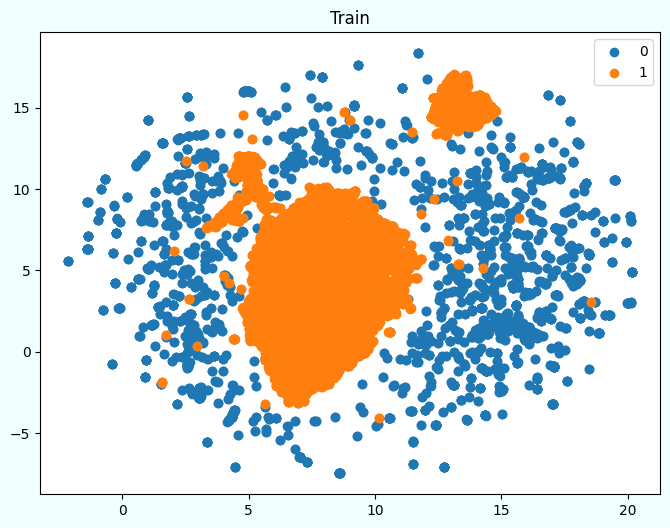

In [6]:
y_train = df_cz['assestment'].values

unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

scaler = StandardScaler().fit(embeddings_table)

reducer = umap.UMAP()
umap_train = reducer.fit_transform(scaler.transform(embeddings_table), y=y_train)

plt.figure(figsize=(8, 6), facecolor="azure")

plt.subplot(1, 1, 1)
for label in np.unique(y_train):
    tmp = umap_train[y_train==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')

plt.legend()
plt.show()

In [7]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use, factor=1):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.repeat( [np.arange(index_to_use.shape[0])], factor, axis=0).reshape(-1)
        
        self.idx = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, idx): 
        item = self.index[idx]
                
        anchor_label = self.labels[item]

        positive_list = self.idx[self.idx!=item][self.labels[self.idx!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.idx[self.idx!=item][self.labels[self.idx!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

class FakeNewsLabel(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]
        
        anchor_claim = self.emb[item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, anchor_label

## TripletLoss

In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Net

In [9]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
#             nn.Linear(768, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, 768)
        x = self.fc(x)
        return x

## Train

In [17]:
embedding_dims = 100
batch_size = 512
epochs = 300
n_workers = 12

In [18]:
train_index, val_index = train_test_split(df_cz.index.values, test_size=0.2, random_state=111)

## Some testing one one kfold

In [19]:
train_ds = FakeNews(embeddings_table, df_cz['assestment'].values, train_index, 10)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

train_ds_label = FakeNewsLabel(embeddings_table, df_cz['assestment'].values, train_index)
train_loader_label = DataLoader(train_ds_label, batch_size=batch_size, shuffle=True, num_workers=n_workers)

val_ds = FakeNews(embeddings_table, df_cz['assestment'].values, val_index, 3)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=n_workers)

test_ds = FakeNewsLabel(embeddings_table_pl, df_pl['assestment'].values, df_pl.index.values)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=n_workers)

In [20]:
model = Network(embedding_dims)
# model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

## Training loop

In [21]:
train_loss_out = []
val_loss_out = []

val_prev = np.inf

if_norm = False

model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)
                
        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    model.eval()
    
    val_loss = []
    for anchor_claim, positive_claim, negative_claim, _ in val_loader:
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = positive_claim.to(device) if if_norm else (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = negative_claim.to(device) if if_norm else (negative_claim / torch.norm(negative_claim) ).to(device)

        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        val_loss.append(loss.cpu().detach().numpy())
    
    model.train()
    
    train_loss_out.append(np.mean(running_loss))
    val_loss_out.append(np.mean(val_loss))
    
    if np.mean(val_loss) < val_prev:
#         print(epoch, f'saved {np.mean(val_loss):.4f} < {val_prev:.4f}')
        val_prev = np.mean(val_loss)
        torch.save(model, 'models/model_4.pt')
        
    if epoch%10 == 0:
        print(f"Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
              f" Val Loss: {np.mean(val_loss):.4f} Best Val loss {val_prev:.4f}")

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 1/300 - Train Loss: 1.6091;  Val Loss: 0.9860 Best Val loss 0.9860
Epoch: 11/300 - Train Loss: 0.0672;  Val Loss: 0.9210 Best Val loss 0.9043
Epoch: 21/300 - Train Loss: 0.0171;  Val Loss: 0.8672 Best Val loss 0.8472
Epoch: 31/300 - Train Loss: 0.0090;  Val Loss: 0.8604 Best Val loss 0.8200
Epoch: 41/300 - Train Loss: 0.0037;  Val Loss: 0.8245 Best Val loss 0.8105
Epoch: 51/300 - Train Loss: 0.0032;  Val Loss: 0.8813 Best Val loss 0.7902
Epoch: 61/300 - Train Loss: 0.0034;  Val Loss: 0.8235 Best Val loss 0.7902
Epoch: 71/300 - Train Loss: 0.0021;  Val Loss: 0.7939 Best Val loss 0.7902
Epoch: 81/300 - Train Loss: 0.0021;  Val Loss: 0.8215 Best Val loss 0.7851
Epoch: 91/300 - Train Loss: 0.0016;  Val Loss: 0.7617 Best Val loss 0.7617
Epoch: 101/300 - Train Loss: 0.0014;  Val Loss: 0.8888 Best Val loss 0.7617
Epoch: 111/300 - Train Loss: 0.0012;  Val Loss: 0.8427 Best Val loss 0.7617
Epoch: 121/300 - Train Loss: 0.0011;  Val Loss: 0.7862 Best Val loss 0.7471
Epoch: 131/300 - Train 

In [22]:
model = torch.load('models/model_4.pt')

In [23]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(train_loader_label):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/31 [00:00<?, ?it/s]

(15451, 100)

In [24]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for anchor_claim, label in tqdm(test_loader):
        anchor_claim = anchor_claim.to(device) if if_norm else (anchor_claim / torch.norm(anchor_claim) ).to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/13 [00:00<?, ?it/s]

(6542, 100)

In [25]:
reducer_nn = umap.UMAP()
scaler_nn = StandardScaler().fit(train_results)

umap_nn_train = train_results if True else reducer_nn.fit_transform(train_results)
umap_nn_test = test_results if True else reducer_nn.transform(test_results)

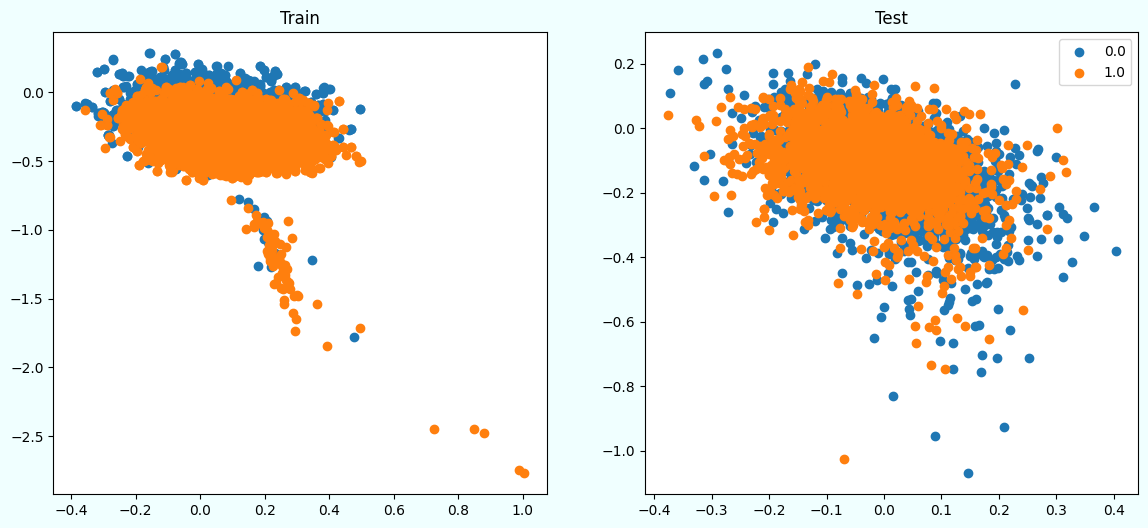

In [26]:
plt.figure(figsize=(14, 6), facecolor="azure")

plt.subplot(1, 2, 1)
for label in np.unique(labels):
    tmp = umap_nn_train[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Train')

plt.subplot(1, 2, 2)
for label in np.unique(test_labels):
    tmp = umap_nn_test[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    plt.title('Test')

plt.legend()
plt.show()

In [27]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear', class_weight='balanced')

In [28]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

out = {
    "Accuracy": np.array(results['test_accuracy']).mean(),
    "Precision": np.array(results['test_precision']).mean(),
    "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']).mean(),
    }

In [29]:
print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

triplet loss lr C1 Accuracy 0.502+-0.000 F1 Score 0.129+-0.000  0.502+-0.000 | 0.129+-0.000


In [30]:
confusion_matrix(y_test_t, y_pred)

array([[3047,  392],
       [2863,  240]])

In [31]:
y_pred_train = clf_lr_1.predict(X_train_t)

In [32]:
confusion_matrix(y_train_t, y_pred_train)

array([[ 2437,   200],
       [ 1035, 11779]])

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_train_t, y_pred_train))

              precision    recall  f1-score   support

         0.0       0.70      0.92      0.80      2637
         1.0       0.98      0.92      0.95     12814

    accuracy                           0.92     15451
   macro avg       0.84      0.92      0.87     15451
weighted avg       0.94      0.92      0.92     15451



In [34]:
print(classification_report(y_test_t, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.89      0.65      3439
         1.0       0.38      0.08      0.13      3103

    accuracy                           0.50      6542
   macro avg       0.45      0.48      0.39      6542
weighted avg       0.45      0.50      0.40      6542

